In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.simplefilter(action='ignore')
sns.set()
plt.style.use("ggplot")

In [2]:
# Funzione per generare un report con figure
def create_figure(fig_num, title):
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=16)
    return plt

# Caricamento del dataset
print("Caricamento del dataset...")
df = pd.read_csv('diabetes.csv')
print(f"Dimensioni del dataset: {df.shape}")

Caricamento del dataset...
Dimensioni del dataset: (768, 9)


                            EDA

In [6]:
print("\n1. ESPLORAZIONE DEI DATI")

# Visualizzazione delle prime righe
print("\nPrime 5 righe del dataset:")
print(df.head())

# Informazioni sul dataset
print("\nInformazioni sul dataset:")
df.info()

# Statistiche descrittive
print("\nStatistiche descrittive:")
df.describe()


1. ESPLORAZIONE DEI DATI

Prime 5 righe del dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pre

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Distribuzione della variabile target:
Non diabetici (0): 500 (65.1%)
Diabetici (1): 268 (34.9%)


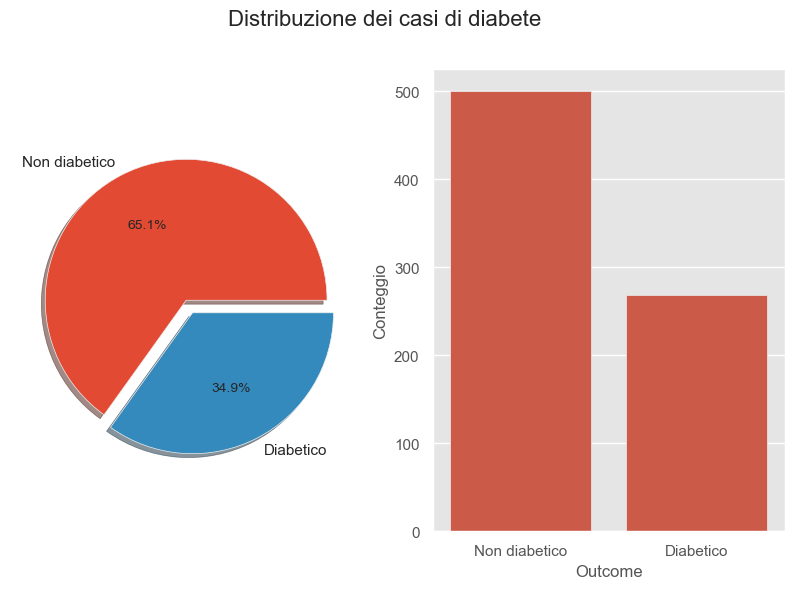

In [7]:
# Distribuzione della variabile target
outcome_counts = df["Outcome"].value_counts()
print(f"\nDistribuzione della variabile target:")
print(f"Non diabetici (0): {outcome_counts[0]} ({outcome_counts[0]*100/len(df):.1f}%)")
print(f"Diabetici (1): {outcome_counts[1]} ({outcome_counts[1]*100/len(df):.1f}%)")

# Distribuzione grafica della variabile target
fig = create_figure(1, "Distribuzione dei casi di diabete")
plt.subplot(1, 2, 1)
df['Outcome'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct="%1.1f%%",
    shadow=True,
    labels=['Non diabetico', 'Diabetico']
)
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.countplot(x='Outcome', data=df)
plt.xticks([0, 1], ['Non diabetico', 'Diabetico'])
plt.xlabel('Outcome')
plt.ylabel('Conteggio')
plt.savefig('distribuzione_target.png')

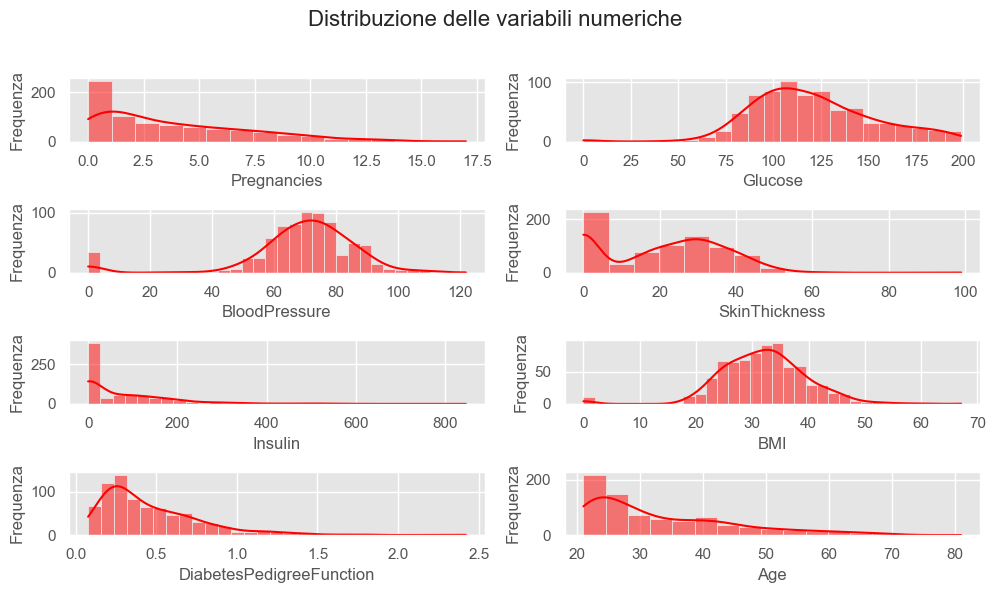

In [8]:
# Visualizzazione della distribuzione delle variabili
fig = create_figure(2, "Distribuzione delle variabili numeriche")
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for i, col in enumerate(cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[col], kde=True, color="red")
    plt.xlabel(col)
    plt.ylabel('Frequenza')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('distribuzione_variabili.png')

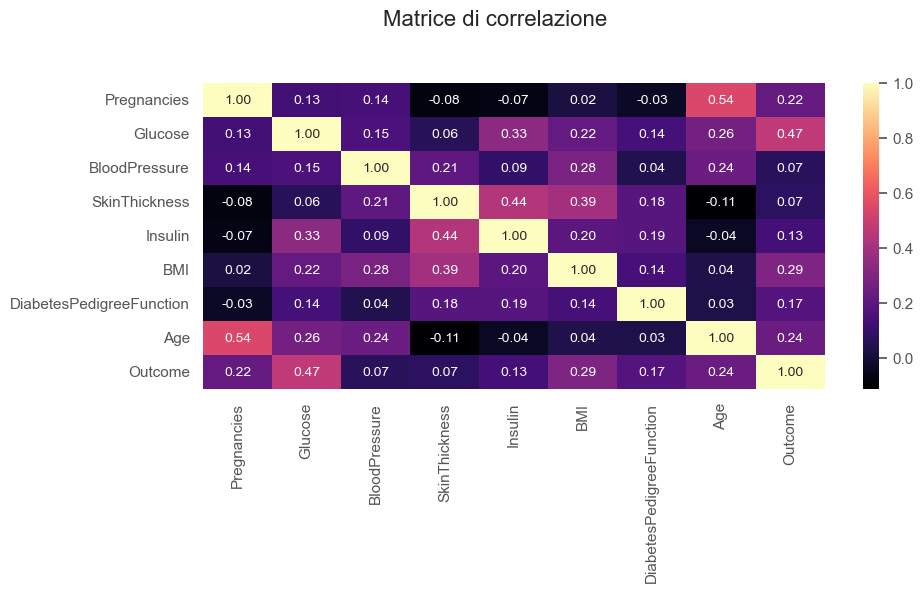

In [9]:
# Matrice di correlazione
fig = create_figure(3, "Matrice di correlazione")
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='magma')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('matrice_correlazione.png')

In [13]:
# Differenze tra gruppi
print("\nDifferenze tra diabetici e non diabetici:")
group_comparison = df.groupby("Outcome").agg({
    'Pregnancies': ['mean', 'median'],
    'Glucose': ['mean', 'median'],
    'BMI': ['mean', 'median'],
    'Age': ['mean', 'median']
})
print(group_comparison.to_string())


Differenze tra diabetici e non diabetici:
        Pregnancies            Glucose               BMI               Age       
               mean median        mean median       mean median       mean median
Outcome                                                                          
0          3.298000    2.0  109.980000  107.0  30.304200  30.05  31.190000   27.0
1          4.865672    4.0  141.257463  140.0  35.142537  34.25  37.067164   36.0


                    PREPROCESSING DEI DATI


In [14]:
print("\n2. PREPROCESSING DEI DATI")

# Identificazione di valori sospetti (0) in colonne dove non dovrebbero esistere
print("\nConteggio di valori 0 nelle colonne (potenziali valori mancanti):")
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} ({zero_count*100/len(df):.1f}%)")

# Sostituzione degli 0 con NaN per le colonne rilevanti
print("\nSostituzione degli 0 con NaN per le colonne dove 0 non è un valore plausibile...")
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.NaN)

# Conteggio dei valori mancanti
print("\nValori mancanti dopo la sostituzione:")
print(df.isnull().sum())


2. PREPROCESSING DEI DATI

Conteggio di valori 0 nelle colonne (potenziali valori mancanti):
Glucose: 5 (0.7%)
BloodPressure: 35 (4.6%)
SkinThickness: 227 (29.6%)
Insulin: 374 (48.7%)
BMI: 11 (1.4%)

Sostituzione degli 0 con NaN per le colonne dove 0 non è un valore plausibile...

Valori mancanti dopo la sostituzione:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [15]:
print("\nImputazione dei valori mancanti con KNNImputer...")
from sklearn.impute import KNNImputer

# Imputazione separata per ciascuna classe di outcome per mantenere la struttura dei dati
# Questo approccio preserva meglio le relazioni tra le variabili
X_diabetic = df[df['Outcome'] == 1].drop('Outcome', axis=1)
X_non_diabetic = df[df['Outcome'] == 0].drop('Outcome', axis=1)

# Configurazione dell'imputatore KNN
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Applicazione dell'imputazione
X_diabetic_imputed = imputer.fit_transform(X_diabetic)
X_non_diabetic_imputed = imputer.fit_transform(X_non_diabetic)

# Riconversione in DataFrame
X_diabetic_imputed = pd.DataFrame(X_diabetic_imputed, columns=X_diabetic.columns, index=X_diabetic.index)
X_non_diabetic_imputed = pd.DataFrame(X_non_diabetic_imputed, columns=X_non_diabetic.columns, index=X_non_diabetic.index)

# Ricostruzione del dataset completo
df_diabetic = X_diabetic_imputed.copy()
df_diabetic['Outcome'] = 1
df_non_diabetic = X_non_diabetic_imputed.copy()
df_non_diabetic['Outcome'] = 0
df = pd.concat([df_diabetic, df_non_diabetic], axis=0).sort_index()

print("Verifica dei valori mancanti dopo l'imputazione:")
print(df.isnull().sum())



Imputazione dei valori mancanti con KNNImputer...
Verifica dei valori mancanti dopo l'imputazione:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


                RILEVAMENTO DEGLI OUTLIER

In [16]:
print("\nRilevamento degli outlier con il metodo IQR:")
# Salta colonne non numeriche o categoriali
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in numeric_features:
    # Salta la colonna Outcome e is_outlier
    if feature in ['Outcome', 'is_outlier']:
        continue
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_outliers = sum((df[feature] < lower) | (df[feature] > upper))
    if n_outliers > 0:
        print(f"{feature}: {n_outliers} outlier rilevati ({n_outliers*100/len(df):.1f}%)")


Rilevamento degli outlier con il metodo IQR:
Pregnancies: 4 outlier rilevati (0.5%)
BloodPressure: 14 outlier rilevati (1.8%)
SkinThickness: 8 outlier rilevati (1.0%)
Insulin: 33 outlier rilevati (4.3%)
BMI: 8 outlier rilevati (1.0%)
DiabetesPedigreeFunction: 29 outlier rilevati (3.8%)
Age: 9 outlier rilevati (1.2%)



Trattamento degli outlier per Insulin...
Limite superiore per Insulin: 332.0


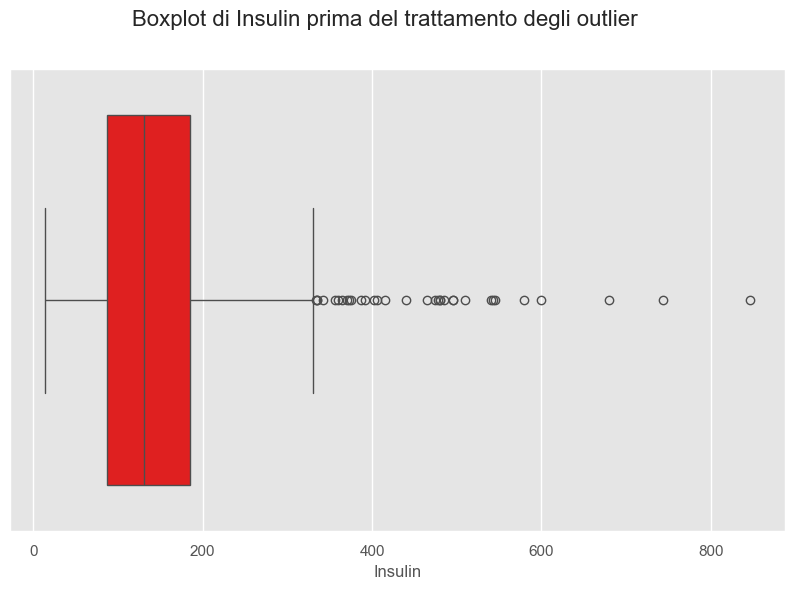

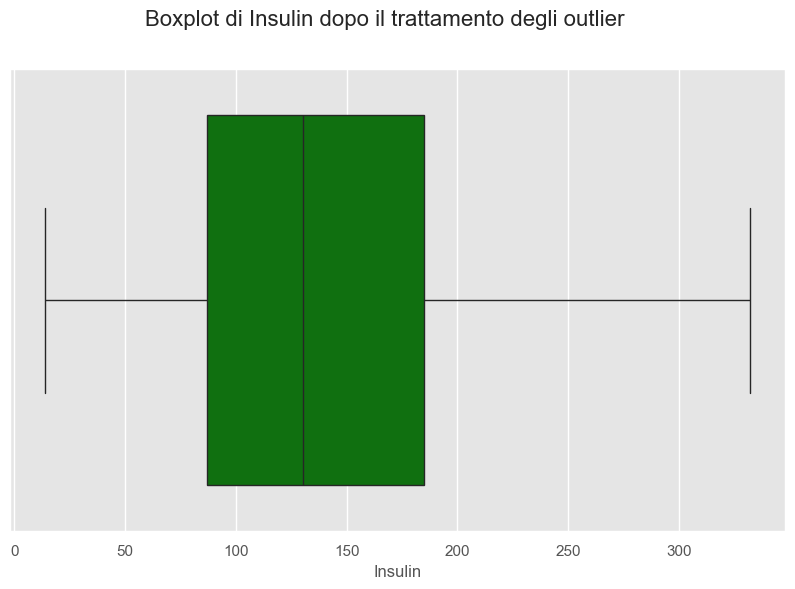

In [18]:
 #Trattamento degli outlier per Insulin (solo come esempio)
print("\nTrattamento degli outlier per Insulin...")
fig = create_figure(4, "Boxplot di Insulin prima del trattamento degli outlier")
sns.boxplot(x=df["Insulin"], color="red")
plt.xlabel("Insulin")
plt.savefig('insulin_prima.png')

Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print(f"Limite superiore per Insulin: {upper}")
df.loc[df['Insulin'] > upper, "Insulin"] = upper

fig = create_figure(5, "Boxplot di Insulin dopo il trattamento degli outlier")
sns.boxplot(x=df["Insulin"], color="green")
plt.xlabel("Insulin")
plt.savefig('insulin_dopo.png')

In [21]:
# Rilevamento degli outlier multivariati con Local Outlier Factor
print("\nRilevamento degli outlier multivariati con Local Outlier Factor...")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outliers = lof.fit_predict(df.drop('Outcome', axis=1))
n_outliers = sum(outliers == -1)
print(f"Outlier multivariati rilevati: {n_outliers} ({n_outliers*100/len(df):.1f}%)")

# Non rimuoviamo gli outlier multivariati per mantenere più dati
# Invece li segnaliamo per una possibile analisi successiva
df['is_outlier'] = outliers == -1


Rilevamento degli outlier multivariati con Local Outlier Factor...
Outlier multivariati rilevati: 39 (5.1%)


                    FEATURE ENGINEERING


In [22]:
print("\nCreazione di categorie di BMI...")
df['BMI_Category'] = pd.cut(
    df['BMI'],
    bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
    labels=['Underweight', 'Normal', 'Overweight', 'Obesity 1', 'Obesity 2', 'Obesity 3']
)

# Creazione di categorie per Insulin
print("\nCreazione di categorie per Insulin...")
df['Insulin_Category'] = pd.cut(
    df['Insulin'],
    bins=[0, 16, 166, float('inf')],
    labels=['Low', 'Normal', 'High']
)

# Creazione di categorie per Glucose
print("\nCreazione di categorie per Glucose...")
df['Glucose_Category'] = pd.cut(
    df['Glucose'],
    bins=[0, 70, 99, 125, float('inf')],
    labels=['Low', 'Normal', 'Prediabetes', 'Diabetes']
)


Creazione di categorie di BMI...

Creazione di categorie per Insulin...

Creazione di categorie per Glucose...


In [24]:

print("\nDistribuzione delle nuove categorie (%):")

categorical_columns = ['BMI_Category', 'Insulin_Category', 'Glucose_Category']

for col in categorical_columns:
    print(f"\n{col}:")
    counts = df[col].value_counts(normalize=True) * 100
    # Trasforma in DataFrame per visualizzazione tabellare pulita
    counts_df = pd.DataFrame(counts).reset_index()
    counts_df.columns = [col, 'Percentuale']
    counts_df['Percentuale'] = counts_df['Percentuale'].map("{:.2f}%".format)
    display(counts_df)



Distribuzione delle nuove categorie (%):

BMI_Category:


,BMI_Category,Percentuale
0,Obesity 1,29.69%
1,Overweight,24.09%
2,Obesity 2,19.66%
3,Normal,13.28%
4,Obesity 3,12.76%
5,Underweight,0.52%



Insulin_Category:


,Insulin_Category,Percentuale
0,Normal,66.15%
1,High,33.46%
2,Low,0.39%



Glucose_Category:


,Glucose_Category,Percentuale
0,Diabetes,38.93%
1,Prediabetes,35.68%
2,Normal,23.96%
3,Low,1.43%


            PREPARAZIONE DEI DATI PER IL MODELLO

In [26]:
print("\n5. PREPARAZIONE DEI DATI PER IL MODELLO")

# Definizione delle colonne di input e target
print("\nPreparazione delle variabili di input e target...")
y = df['Outcome']

# Separazione delle colonne numeriche e categoriche
numeric_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
categorical_columns = ['BMI_Category', 'Insulin_Category', 'Glucose_Category']

# Divisione in train e test set
print("\nDivisione in train e test set...")
X_train, X_test, y_train, y_test = train_test_split(
    df[numeric_columns + categorical_columns],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Dimensioni del training set: {X_train.shape}")
print(f"Dimensioni del test set: {X_test.shape}")

# Creazione di una pipeline di preprocessing
print("\nCreazione della pipeline di preprocessing...")
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)


5. PREPARAZIONE DEI DATI PER IL MODELLO

Preparazione delle variabili di input e target...

Divisione in train e test set...
Dimensioni del training set: (614, 11)
Dimensioni del test set: (154, 11)

Creazione della pipeline di preprocessing...


                ADDESTRAMENTO DEL MODELLO RANDOM FOREST

In [29]:
print("\n6. ADDESTRAMENTO DEL MODELLO RANDOM FOREST")

# Pipeline completa con Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Cross-validation per valutare la performance del modello base
print("\nValutazione del modello con cross-validation...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Accuracy con 5-fold CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Ottimizzazione degli iperparametri
print("\nOttimizzazione degli iperparametri...")
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}
print("\nIperparametri ottimizzati")


6. ADDESTRAMENTO DEL MODELLO RANDOM FOREST

Valutazione del modello con cross-validation...
Accuracy con 5-fold CV: 0.7866 ± 0.0226

Ottimizzazione degli iperparametri...

Iperparametri ottimizzati


In [30]:
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Migliori iperparametri
print("\nMigliori iperparametri trovati:")
print(grid_search.best_params_)
print(f"Miglior accuracy in CV: {grid_search.best_score_:.4f}")

# Modello finale con i migliori iperparametri
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits

Migliori iperparametri trovati:
{'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Miglior accuracy in CV: 0.7948


                    VALIDAZIONE DEL MODELLO

In [31]:
print("\n7. VALIDAZIONE DEL MODELLO")

# Validazione con k-fold cross validation
print("\nValidazione con 5-fold cross validation...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in scoring_metrics:
    cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring=metric)
    print(f"{metric.capitalize()}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Valutazione del modello sul test set
print("\nValutazione del modello sul test set:")
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Metriche di performance
accuracy = accuracy_score(y_test, y_pred)
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")



7. VALIDAZIONE DEL MODELLO

Validazione con 5-fold cross validation...
Accuracy: 0.7785 ± 0.0149
Precision: 0.6975 ± 0.0588
Recall: 0.6403 ± 0.0501
F1: 0.6656 ± 0.0402
Roc_auc: 0.8526 ± 0.0244

Valutazione del modello sul test set:
Accuracy: 0.7662
Precision: 0.6800
Recall: 0.6296
F1 Score: 0.6538
ROC AUC Score: 0.8467


In [32]:
# Matrice di confusione
print("\nMatrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Matrice di confusione:
[[84 16]
 [20 34]]


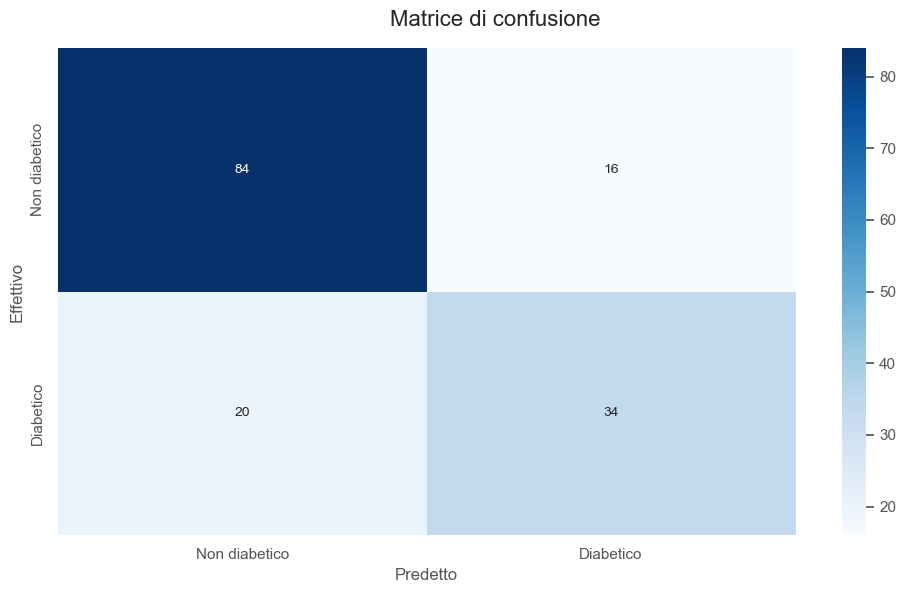

In [33]:
# Visualizzazione della matrice di confusione
fig = create_figure(6, "Matrice di confusione")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non diabetico', 'Diabetico'],
            yticklabels=['Non diabetico', 'Diabetico'])
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.tight_layout()
plt.savefig('confusion_matrix.png')


Report di classificazione:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       100
           1       0.68      0.63      0.65        54

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



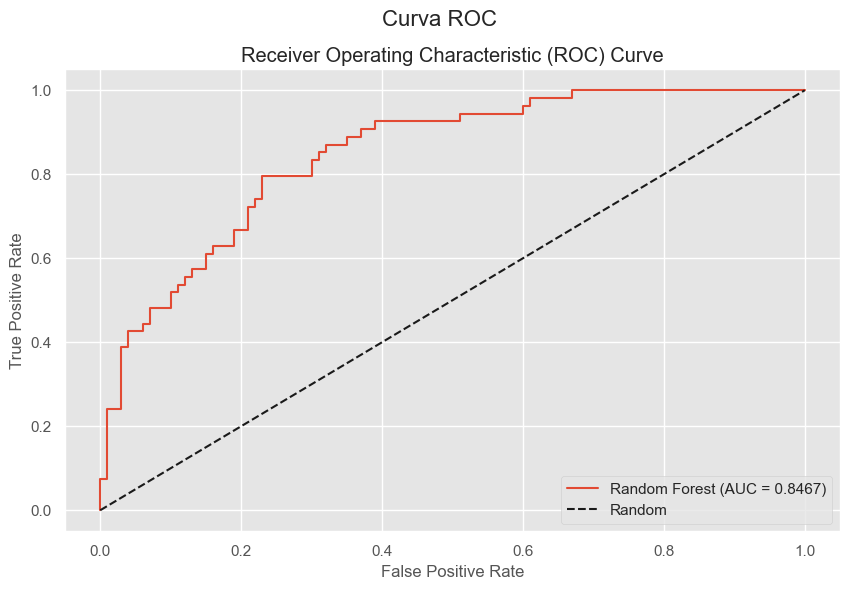

In [34]:
print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))

# Curva ROC
fig = create_figure(7, "Curva ROC")
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')


8. ANALISI DELL'IMPORTANZA DELLE FEATURE E INTERPRETABILITÀ

Top 10 feature per importanza:
                     Feature  Importance
1                    Glucose    0.208580
4                    Insulin    0.197434
5                        BMI    0.099251
7                        Age    0.091919
3              SkinThickness    0.091032
6   DiabetesPedigreeFunction    0.079495
14   Insulin_Category_Normal    0.053941
0                Pregnancies    0.051437
2              BloodPressure    0.047966
16   Glucose_Category_Normal    0.028973

Calcolo dell'importanza delle feature con analisi delle permutazioni...


ValueError: All arrays must be of the same length

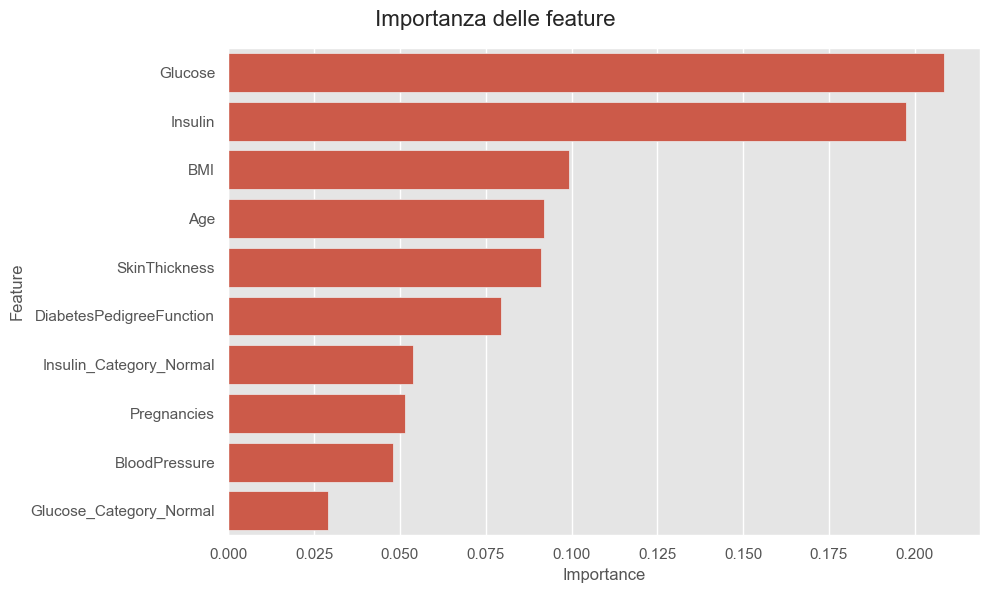

In [35]:
print("\n8. ANALISI DELL'IMPORTANZA DELLE FEATURE E INTERPRETABILITÀ")

# Estrazione delle importanze delle feature
feature_importances = best_rf.named_steps['classifier'].feature_importances_

# Ottieni i nomi delle feature dopo il preprocessing
preprocessor = best_rf.named_steps['preprocessor']
cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)
all_features = np.concatenate([numeric_columns, cat_features])

# Visualizzazione dell'importanza delle feature
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 feature per importanza:")
print(feature_importance_df.head(10))

fig = create_figure(8, "Importanza delle feature")
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.tight_layout()
plt.savefig('feature_importance.png')

# Analisi delle permutazioni per una valutazione più robusta dell'importanza
print("\nCalcolo dell'importanza delle feature con analisi delle permutazioni...")
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_rf, X_test, y_test,
                                        n_repeats=10,
                                        random_state=42)

perm_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 feature secondo l'analisi delle permutazioni:")
print(perm_importance_df.head(10))

fig = create_figure(9, "Importanza delle feature (analisi delle permutazioni)")
plt.errorbar(
    x=perm_importance_df['Importance'].head(10),
    y=range(10),
    xerr=perm_importance_df['Std'].head(10),
    fmt='o'
)
plt.yticks(range(10), perm_importance_df['Feature'].head(10))
plt.xlabel('Importanza (riduzione della performance)')
plt.title('Importanza delle feature (analisi delle permutazioni)')
plt.tight_layout()
plt.savefig('permutation_importance.png')


Creazione dei Partial Dependence Plots (PDP) per le feature più importanti...


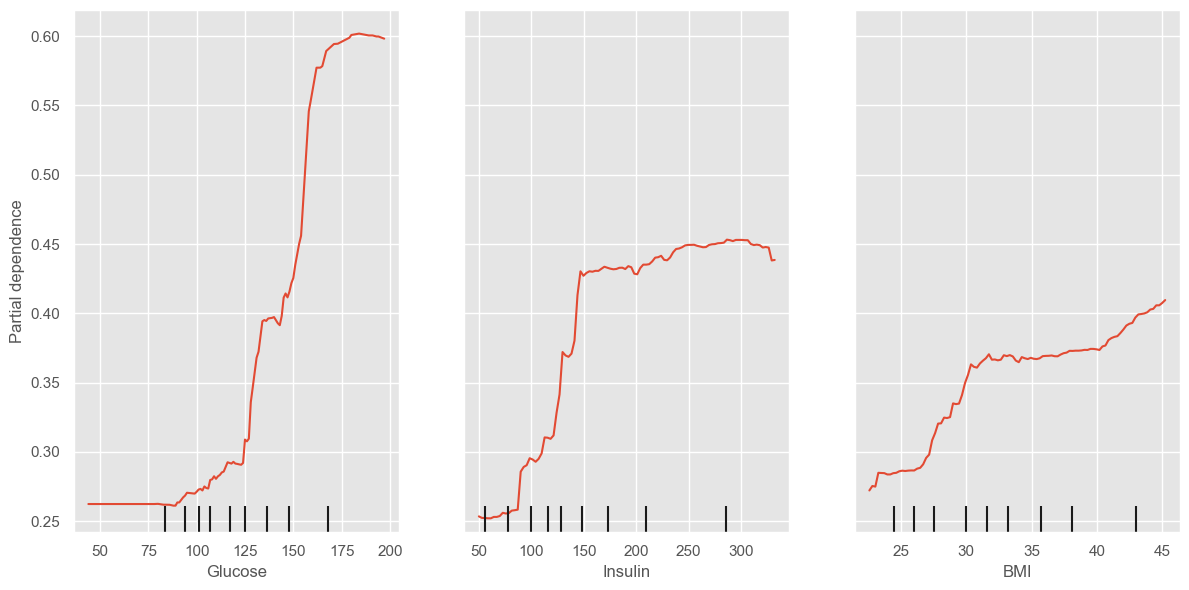

In [36]:
# PDPs (Partial Dependence Plots) per le feature più importanti
try:
    print("\nCreazione dei Partial Dependence Plots (PDP) per le feature più importanti...")
    from sklearn.inspection import PartialDependenceDisplay

    # Troviamo le feature numeriche più importanti
    top_numeric_features = [f for f in feature_importance_df['Feature']
                           if f in numeric_columns][:3]

    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_test,
        top_numeric_features,
        kind="average",
        ax=ax
    )
    plt.tight_layout()
    plt.savefig('pdp_plots.png')
except Exception as e:
    print(f"Impossibile creare i PDP plots: {e}")


In [37]:
print("\n9. SALVATAGGIO DEL MODELLO")
joblib.dump(best_rf, 'diabetes_rf_model.pkl')
print("Modello salvato come 'diabetes_rf_model.pkl'")


9. SALVATAGGIO DEL MODELLO
Modello salvato come 'diabetes_rf_model.pkl'


                                                        CREAZIONE DI UNA FUNZIONE DI PREVISIONE

In [38]:
print("\n10. FUNZIONE DI PREVISIONE PER NUOVI DATI")

def predict_diabetes(model, new_data):
    """
    Effettua previsioni su nuovi dati.

    Args:
        model: Modello addestrato
        new_data: DataFrame con i dati del paziente

    Returns:
        Probabilità di diabete e predizione
    """
    # Assicurarsi che tutte le colonne necessarie siano presenti
    required_cols = numeric_columns + categorical_columns
    for col in required_cols:
        if col not in new_data.columns:
            raise ValueError(f"Colonna mancante: {col}")

    # Effettuare la previsione
    prob = model.predict_proba(new_data[required_cols])[0, 1]
    pred = 1 if prob >= 0.5 else 0

    # Calcolo del rischio
    if prob < 0.2:
        risk_level = "Basso"
    elif prob < 0.5:
        risk_level = "Moderato"
    elif prob < 0.7:
        risk_level = "Alto"
    else:
        risk_level = "Molto alto"

    return {
        "probability": prob,
        "prediction": pred,
        "risk_level": risk_level
    }


10. FUNZIONE DI PREVISIONE PER NUOVI DATI


In [47]:
# Esempio di utilizzo della funzione di previsione in Jupyter Notebook

print("\nEsempio di utilizzo della funzione di previsione:")

sample_patient = X_test.iloc[0:1].copy()  # Primo paziente del test set come esempio

result = predict_diabetes(best_rf, sample_patient)

print("Dati del paziente:")
display(sample_patient[numeric_columns].T)  # Trasposto per visualizzazione verticale pulita

print(f"Probabilità di diabete: {result['probability']:.4f}")
print(f"Predizione: {'Diabetico' if result['prediction'] == 1 else 'Non diabetico'}")
print(f"Livello di rischio: {result['risk_level']}")
print(f"Valore reale: {'Diabetico' if y_test.iloc[0] == 1 else 'Non diabetico'}")



Esempio di utilizzo della funzione di previsione:
Dati del paziente:


,44
Pregnancies,7.000000
Glucose,159.000000
BloodPressure,64.000000
SkinThickness,31.965374
Insulin,189.938105
BMI,27.400000
DiabetesPedigreeFunction,0.294000
Age,40.000000


Probabilità di diabete: 0.6491
Predizione: Diabetico
Livello di rischio: Alto
Valore reale: Non diabetico
